## Data Loading and Basic info

In [1]:
import pandas as pd

df = pd.read_csv(r"../data/processed_natural_gas_data.csv", parse_dates=['date'])

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1461 non-null   datetime64[ns]
 1   price        1461 non-null   float64       
 2   temperature  1461 non-null   float64       
 3   hdd          1461 non-null   float64       
 4   cdd          1461 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB
None
                      date        price  temperature          hdd          cdd
count                 1461  1461.000000  1461.000000  1461.000000  1461.000000
mean   2023-08-09 00:00:00     3.916548    49.826249    18.916593     3.742842
min    2021-08-09 00:00:00     1.575000    -4.805470     0.000000     0.000000
25%    2022-08-09 00:00:00     2.551000    30.488937     0.000000     0.000000
50%    2023-08-09 00:00:00     3.334000    50.904449    14.095551     0.000000
75%    2024-

## Check for missing values

In [3]:
print(df.isna().sum())

date           0
price          0
temperature    0
hdd            0
cdd            0
dtype: int64


## Initial Data Exploration - Henry Hub Natural Gas Prices
This time series plot shows Henry Hub natural gas prices from July 2021 to July 2025. The data displays several notable characteristics:
- Significant price volatility with values ranging from ~$1.5 to $9.5 USD
- A major price surge in 2022 reaching peak levels around $9.5
- Apparent trending behavior and structural changes over time
- High volatility periods followed by more stable phases

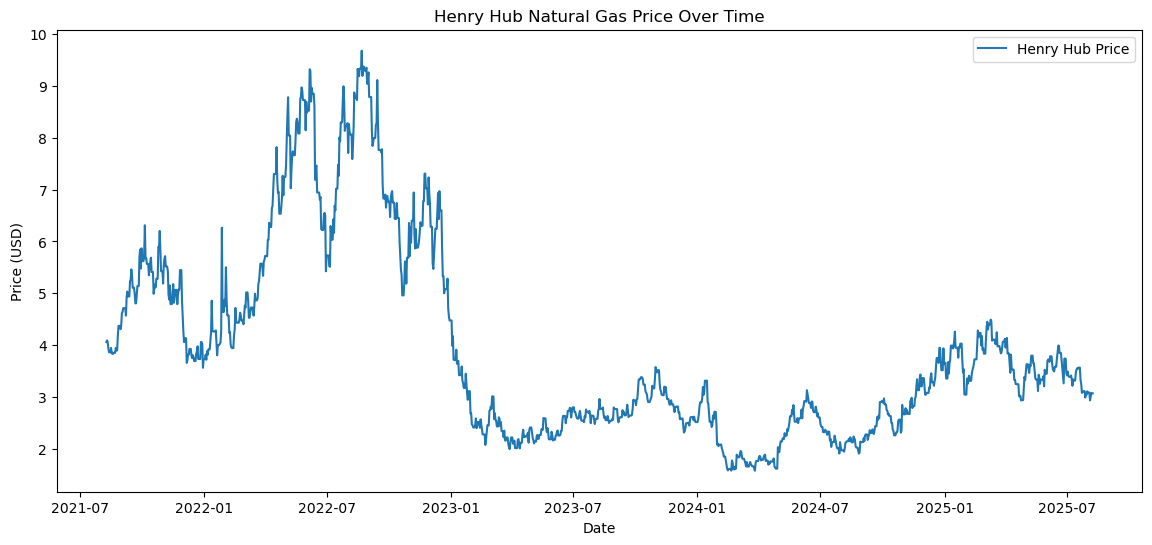

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['date'], df['price'], label='Henry Hub Price')
plt.title("Henry Hub Natural Gas Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

## Daily Average Temperature Data
This plot displays daily average temperature readings from July 2021 to July 2025. The data shows clear seasonal patterns characteristic of temperature data:
- Strong cyclical behavior with regular annual peaks (~ 100°F in summer) and lows (~0-10°F in winter)
- Consistent seasonal amplitude across the 4-year period
- High daily volatility around the seasonal trend
- Apparent stationarity around a seasonal mean, unlike the gas price data

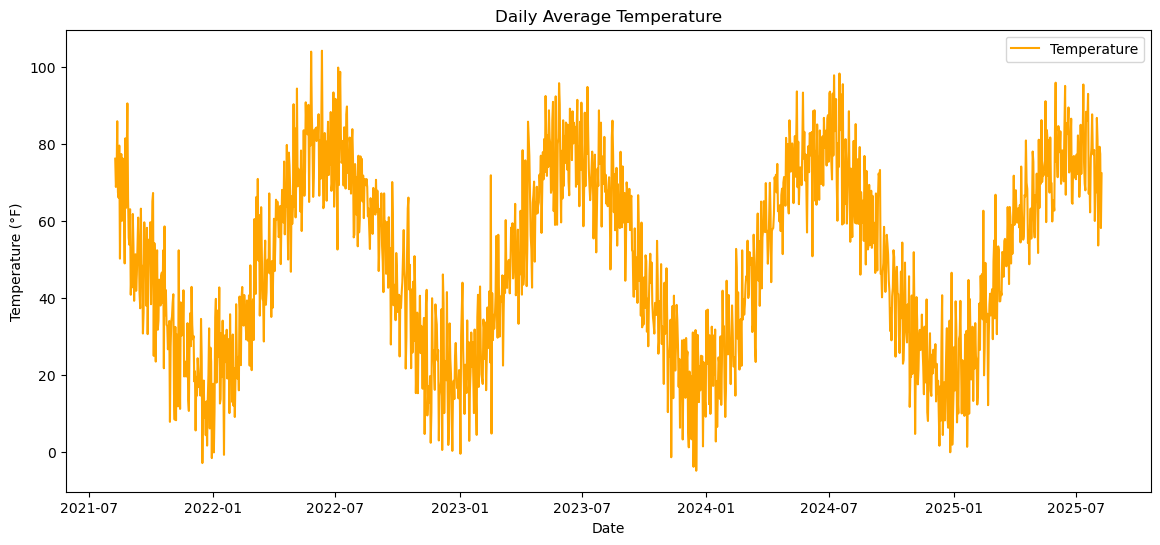

In [7]:
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['temperature'], label='Temperature', color='orange')
plt.title("Daily Average Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.show()

## Variable Correlation Analysis
This correlation heatmap examines relationships between natural gas prices and weather-related variables:

**Key findings:**
- **Price vs Temperature**: Very weak correlation (0.039), suggesting temperature alone doesn't directly drive prices
- **Temperature vs HDD**: Strong negative correlation (-0.97), as expected since Heating Degree Days increase when temperatures drop
- **Temperature vs CDD**: Strong positive correlation (0.72), as Cooling Degree Days increase with higher temperatures  
- **Price correlations**: Weak relationships with HDD (-0.04) and CDD (0.023) suggest that simple linear correlations may not capture the complex relationship between weather and gas prices

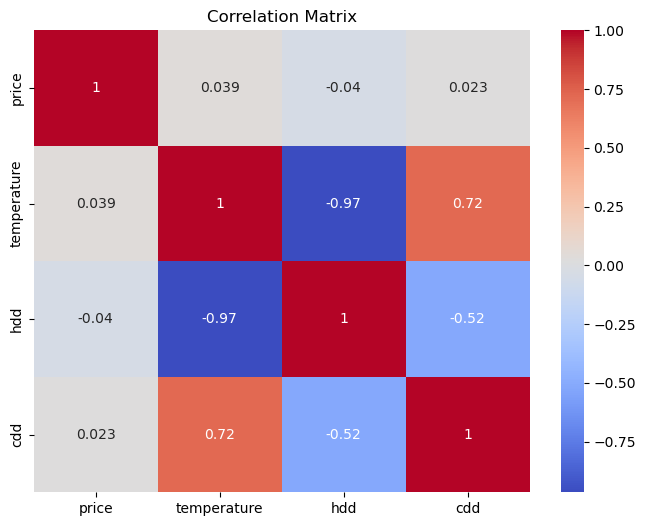

In [9]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df[['price', 'temperature', 'hdd', 'cdd']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Before proceeding with time series modeling, we need to analyze the statistical properties of this series to determine if it's stationary and identify appropriate modeling approaches. To do that we use two common correlation functions

## Autocorrelation Function (ACF) Analysis
The ACF plot shows slow decay in autocorrelation values, with significant correlations persisting for many lags. This gradual decline is characteristic of a non-stationary time series, suggesting the presence of trends or unit roots in the original price data.

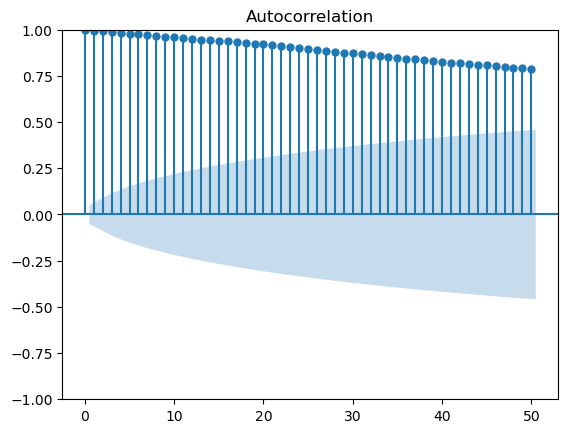

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['price'], lags=50)
plt.show()

## Partial Autocorrelation Function (PACF) Analysis  
The PACF shows a dominant spike at first 2 lags with near-zero values for higher lags. This pattern suggests an AR(1) or AR(2) process once the data is made stationary, indicating that most of the predictable structure can be explained by the previous 1-2 observations.

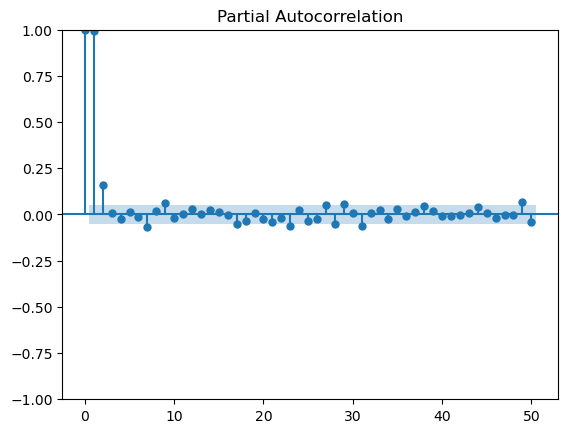

In [14]:
plot_pacf(df['price'], lags=50)
plt.show()

## Stationarity Test - Augmented Dickey-Fuller
ADF test p-value of 0.46 > 0.05, failing to reject the unit root hypothesis and confirming the series is non-stationary. This validates what we observed in the ACF plot and indicates we need to difference the data before modeling.

In [16]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['price'])
print(f'p-value: {adf_test[1]}')

p-value: 0.4595965064268841


## Data Transformation - First Differencing
As original price series showed non-stationary behavior, we apply first differencing to make the series suitable for time series modeling:

- First differencing transforms the data from price levels to price changes
- This removes trends and makes the series stationary around a constant mean

In [18]:
df['price_diff'] = df['price'].diff()

adf_test = adfuller(df['price_diff'].dropna())
print(f'p-value: {adf_test[1]}')

p-value: 2.88552274288852e-26


**Stationarity Test Results:**
After differencing, the ADF test yields a p-value of 2.89e-26 (highly significant), strongly rejecting the unit root hypothesis. The differenced series is now stationary and ready for ARIMA modeling.

## Saving the changes to a new csv file

In [23]:
df.to_csv('../data/model_ready_data.csv')